# Ячейка 1: Импорты и настройки

In [7]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score

# Настройки графиков
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore') # Игнорируем предупреждения для чистоты вывода

# Пути (относительные, как в задании)
DATA_DIR = "data"
ARTIFACTS_DIR = "artifacts"
FIG_DIR = os.path.join(ARTIFACTS_DIR, "figures")
LABELS_DIR = os.path.join(ARTIFACTS_DIR, "labels")

# Создаем папки, если нет
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(LABELS_DIR, exist_ok=True)

# Глобальные словари для сбора итогов
METRICS_SUMMARY = {}
BEST_CONFIGS = {}

# Ячейка 2: Вспомогательные функции (Preprocess, Metrics, Plotting)

In [8]:
def load_and_preprocess(filename):
    """
    Загрузка, отделение ID и препроцессинг (Imputation + Scaling).
    """
    path = os.path.join(DATA_DIR, filename)
    df = pd.read_csv(path)

    # 1. Отделяем ID
    if 'sample_id' in df.columns:
        sample_ids = df['sample_id']
        X_raw = df.drop(columns=['sample_id'])
    else:
        sample_ids = df.index
        X_raw = df

    print(f"--- Loading {filename} ---")
    print(f"Shape: {X_raw.shape}")
    print("Missing values per feature:\n", X_raw.isna().sum())

    # 2. Pipeline препроцессинга
    # SimpleImputer - на случай пропусков (хотя в синтетике 1-3 их может не быть)
    # StandardScaler - обязательно для distance-based методов
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    X_scaled = preprocessor.fit_transform(X_raw)

    # Возвращаем DataFrame для удобства (с названиями колонок)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X_raw.columns)

    return sample_ids, X_scaled_df

def calculate_internal_metrics(X, labels):
    """
    Считает Silhouette, DB, CH.
    Для DBSCAN исключает шум (-1) из подсчета метрик, но возвращает долю шума.
    """
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    # Если кластеров < 2 (или только шум), метрики не определены
    if n_clusters < 2:
        return {
            "silhouette": -1, "davies_bouldin": 10, "calinski_harabasz": 0,
            "n_clusters": n_clusters, "noise_ratio": 0
        }

    # Логика для шума (DBSCAN)
    if -1 in unique_labels:
        # Считаем маску "не шум"
        mask = labels != -1
        noise_ratio = np.sum(~mask) / len(labels)

        if np.sum(mask) < 2: # Если после удаления шума точек мало
             return {"silhouette": -1, "noise_ratio": noise_ratio}

        sil = silhouette_score(X[mask], labels[mask])
        db = davies_bouldin_score(X[mask], labels[mask])
        ch = calinski_harabasz_score(X[mask], labels[mask])
    else:
        noise_ratio = 0.0
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        ch = calinski_harabasz_score(X, labels)

    return {
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch,
        "n_clusters": n_clusters,
        "noise_ratio": noise_ratio
    }

def plot_pca_clusters(X, labels, title, filename_suffix):
    """
    Визуализация PCA (2D)
    """
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    # Раскраска: палитра deep, шум (-1) красим в серый, если есть
    unique = np.unique(labels)
    palette = sns.color_palette("deep", len(unique))

    # Если есть шум, сделаем его серым/черным вручную, но проще через hue
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='tab10', s=50, alpha=0.8)
    plt.title(f"PCA 2D: {title}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    save_path = os.path.join(FIG_DIR, f"pca_{filename_suffix}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def plot_metric_curve(param_values, metrics, param_name, metric_name, title, filename_suffix):
    """
    График метрики от параметра (например, Silhouette vs K)
    """
    plt.figure(figsize=(8, 5))
    plt.plot(param_values, metrics, marker='o')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(metric_name)
    plt.grid(True)

    save_path = os.path.join(FIG_DIR, f"curve_{filename_suffix}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Ячейка 3: Обработка Dataset 01 (KMeans + Agglomerative)

--- Loading S07-hw-dataset-01.csv ---
Shape: (12000, 8)
Missing values per feature:
 f01    0
f02    0
f03    0
f04    0
f05    0
f06    0
f07    0
f08    0
dtype: int64

--- Processing ds01 with KMeans ---
Best K (Silhouette): 2


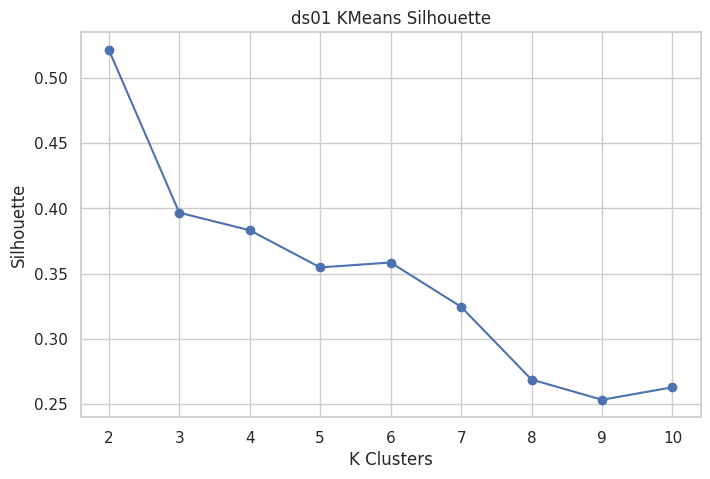


--- Processing ds01 with Agglomerative ---


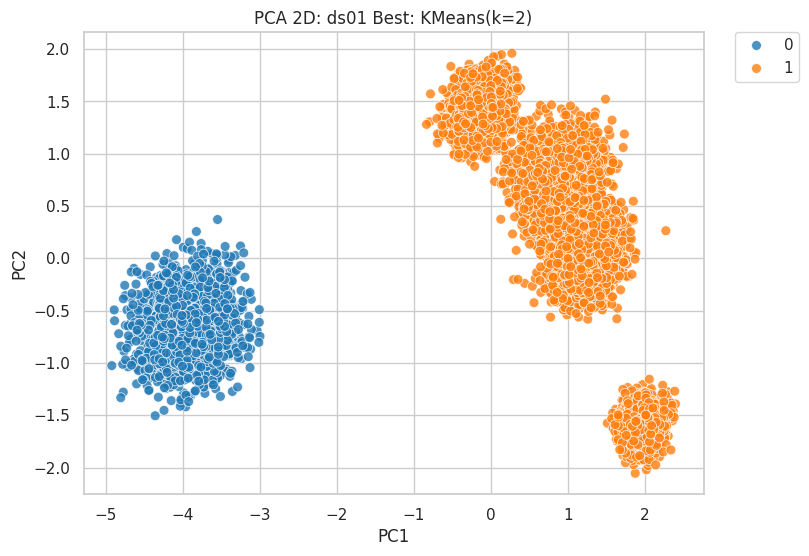

In [9]:
# --- DATASET 01 ---
# Характеристики: Разные шкалы, шум. Ожидаем, что KMeans справится хорошо после Scaling.
DS_NAME = "ds01"
FILENAME = "S07-hw-dataset-01.csv"

ids_1, X_1 = load_and_preprocess(FILENAME)

results_km = []
k_range = range(2, 11)

# 1. KMeans Experiment
print(f"\n--- Processing {DS_NAME} with KMeans ---")
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_1)
    m = calculate_internal_metrics(X_1, labels)
    m['k'] = k
    results_km.append(m)

# Находим лучшее K по Silhouette
best_km_idx = np.argmax([r['silhouette'] for r in results_km])
best_k = results_km[best_km_idx]['k']
print(f"Best K (Silhouette): {best_k}")

# График Silhouette vs K
sil_scores = [r['silhouette'] for r in results_km]
plot_metric_curve(k_range, sil_scores, "K Clusters", "Silhouette", f"{DS_NAME} KMeans Silhouette", f"{DS_NAME}_kmeans_sil")

# 2. Agglomerative Clustering (Alternative)
print(f"\n--- Processing {DS_NAME} with Agglomerative ---")
results_agg = []
for k in range(2, 6): # Пробуем небольшое кол-во кластеров
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_1)
    m = calculate_internal_metrics(X_1, labels)
    m['k'] = k
    results_agg.append(m)

# Сохраняем "лучшее" решение (пусть это будет KMeans с best_k)
final_km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_labels_1 = final_km.fit_predict(X_1)

# Визуализация лучшего решения
plot_pca_clusters(X_1, final_labels_1, f"{DS_NAME} Best: KMeans(k={best_k})", f"{DS_NAME}_best")

# Сохранение результатов
METRICS_SUMMARY[DS_NAME] = {
    "KMeans_Best": results_km[best_km_idx],
    "Agglomerative_Example": results_agg[0] # просто для примера
}
BEST_CONFIGS[DS_NAME] = {"method": "KMeans", "params": {"n_clusters": int(best_k)}}
pd.DataFrame({'sample_id': ids_1, 'cluster_label': final_labels_1}).to_csv(os.path.join(LABELS_DIR, f"labels_{DS_NAME}.csv"), index=False)

# Ячейка 4: Обработка Dataset 02 (Нелинейность -> KMeans vs DBSCAN)

--- Loading S07-hw-dataset-02.csv ---
Shape: (8000, 3)
Missing values per feature:
 x1         0
x2         0
z_noise    0
dtype: int64

--- Processing ds02 with KMeans ---

--- Processing ds02 with DBSCAN ---
Best DBSCAN Eps: 0.6444444444444445, Silhouette: 0.279


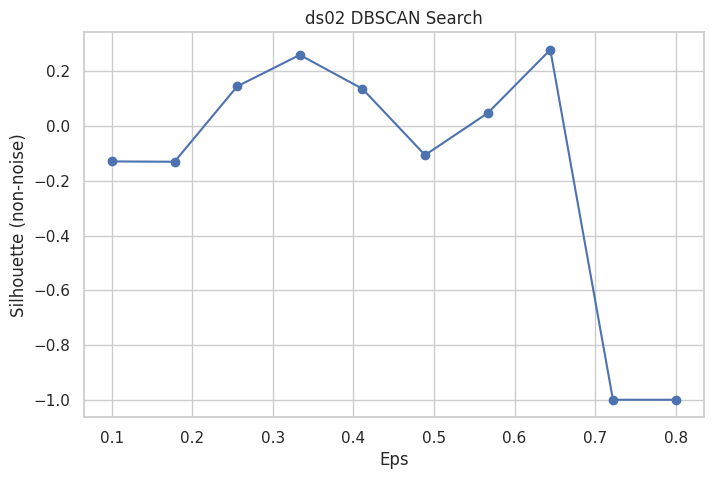

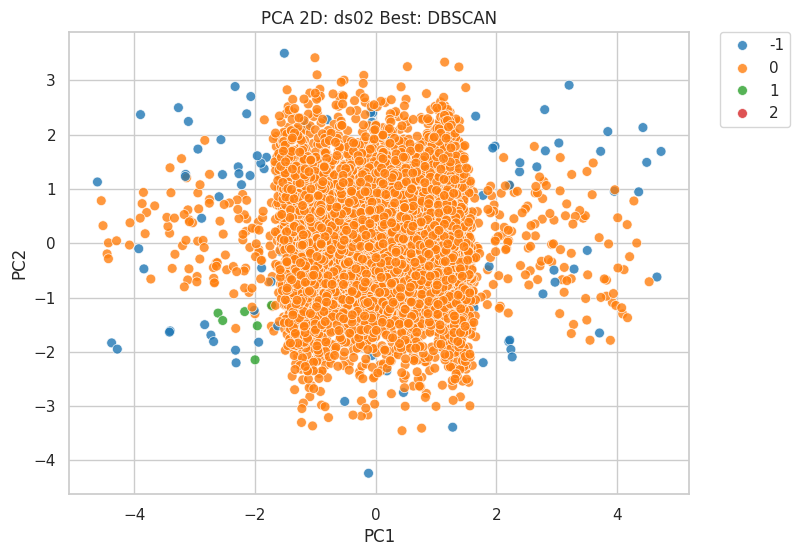

In [10]:
# --- DATASET 02 ---
# Характеристики: Нелинейность (луны/кольца), выбросы. KMeans провалится, DBSCAN должен победить.
DS_NAME = "ds02"
FILENAME = "S07-hw-dataset-02.csv"

ids_2, X_2 = load_and_preprocess(FILENAME)

# 1. KMeans (для демонстрации неудачи)
print(f"\n--- Processing {DS_NAME} with KMeans ---")
# Возьмем k=2..5
sil_km = []
for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbls = km.fit_predict(X_2)
    sil_km.append(silhouette_score(X_2, lbls))

# Визуализируем KMeans (просто чтобы убедиться, что он режет "плохо")
km_bad = KMeans(n_clusters=2, random_state=42, n_init=10)
lbls_bad = km_bad.fit_predict(X_2)
# Можно раскомментировать, если хотим сохранить "плохой" график
# plot_pca_clusters(X_2, lbls_bad, f"{DS_NAME} KMeans Fail", f"{DS_NAME}_kmeans_fail")

# 2. DBSCAN (Подбор eps)
print(f"\n--- Processing {DS_NAME} with DBSCAN ---")
results_db = []
# Диапазон EPS зависит от масштабирования (после StandardScaler ~ 0.1 ... 1.0 обычно)
eps_range = np.linspace(0.1, 0.8, 10)
best_db_sil = -2
best_eps = 0.3
best_labels_db = None

for eps in eps_range:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_2)

    m = calculate_internal_metrics(X_2, labels)
    m['eps'] = round(eps, 2)
    results_db.append(m)

    # Ищем максимум silhouette, но игнорируем случаи, где всё шум или 1 кластер
    if m['n_clusters'] > 1 and m['silhouette'] > best_db_sil:
        best_db_sil = m['silhouette']
        best_eps = eps
        best_labels_db = labels

print(f"Best DBSCAN Eps: {best_eps}, Silhouette: {best_db_sil:.3f}")

# График Silhouette vs Eps
valid_sils = [r['silhouette'] for r in results_db]
plot_metric_curve(eps_range, valid_sils, "Eps", "Silhouette (non-noise)", f"{DS_NAME} DBSCAN Search", f"{DS_NAME}_dbscan_eps")

# Финализируем лучшее решение (скорее всего DBSCAN)
if best_labels_db is None:
    # Fallback если DBSCAN не нашел кластеров
    final_labels_2 = lbls_bad
    chosen_method = "KMeans (Fallback)"
else:
    final_labels_2 = best_labels_db
    chosen_method = "DBSCAN"

plot_pca_clusters(X_2, final_labels_2, f"{DS_NAME} Best: {chosen_method}", f"{DS_NAME}_best")

METRICS_SUMMARY[DS_NAME] = {
    "KMeans_k2": {"silhouette": sil_km[0]}, # k=2 index 0
    "DBSCAN_Best": next((r for r in results_db if r['eps'] == round(best_eps, 2)), None)
}
BEST_CONFIGS[DS_NAME] = {"method": chosen_method, "params": {"eps": round(best_eps, 2)}}
pd.DataFrame({'sample_id': ids_2, 'cluster_label': final_labels_2}).to_csv(os.path.join(LABELS_DIR, f"labels_{DS_NAME}.csv"), index=False)

# Ячейка 5: Обработка Dataset 03 (Плотность -> DBSCAN vs KMeans)

--- Loading S07-hw-dataset-03.csv ---
Shape: (15000, 4)
Missing values per feature:
 x1         0
x2         0
f_corr     0
f_noise    0
dtype: int64

--- Processing ds03 with KMeans ---
KMeans Best K: 3 (Sil: 0.316)


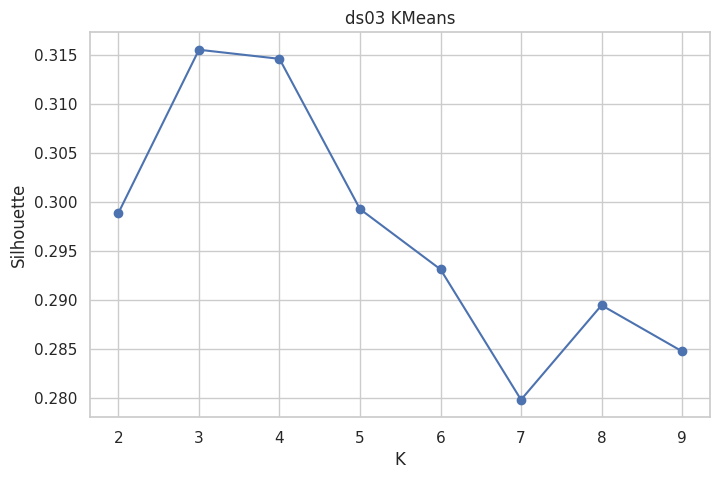


--- Processing ds03 with DBSCAN ---
DBSCAN Best Eps: 0.6, Sil: 0.10112221220804056


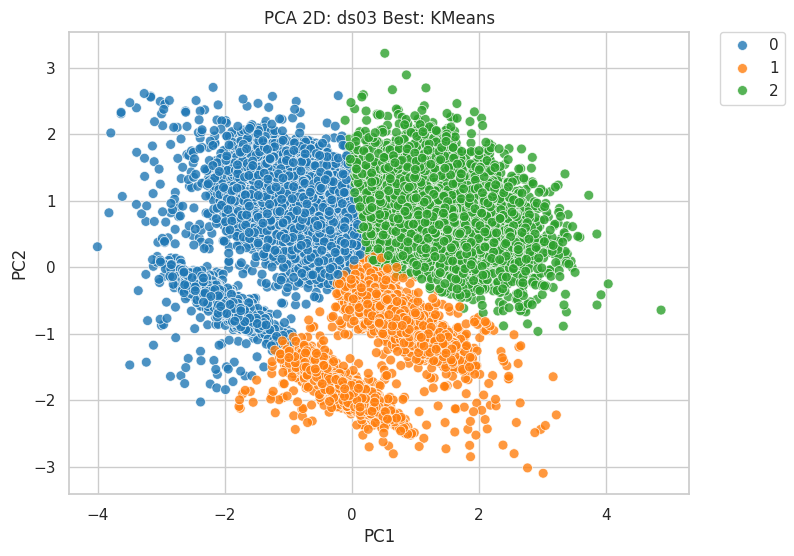

In [11]:
# --- DATASET 03 ---
# Характеристики: Кластеры разной плотности + шум.
DS_NAME = "ds03"
FILENAME = "S07-hw-dataset-03.csv"

ids_3, X_3 = load_and_preprocess(FILENAME)

# 1. KMeans
print(f"\n--- Processing {DS_NAME} with KMeans ---")
k_vals = []
sil_vals = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbls = km.fit_predict(X_3)
    k_vals.append(k)
    sil_vals.append(silhouette_score(X_3, lbls))

best_k3_idx = np.argmax(sil_vals)
best_k3 = k_vals[best_k3_idx]
print(f"KMeans Best K: {best_k3} (Sil: {sil_vals[best_k3_idx]:.3f})")

plot_metric_curve(k_vals, sil_vals, "K", "Silhouette", f"{DS_NAME} KMeans", f"{DS_NAME}_kmeans_sil")

# 2. DBSCAN
print(f"\n--- Processing {DS_NAME} with DBSCAN ---")
# Разная плотность - сложно для DBSCAN с одним eps, но попробуем найти компромисс
results_db3 = []
eps_range_3 = np.linspace(0.15, 0.6, 10)
best_db3_sil = -2
best_labels_db3 = None
best_eps3 = 0.3

for eps in eps_range_3:
    db = DBSCAN(eps=eps, min_samples=4) # чуть меньше min_samples
    labels = db.fit_predict(X_3)

    m = calculate_internal_metrics(X_3, labels)
    m['eps'] = round(eps, 2)
    results_db3.append(m)

    if m['n_clusters'] >= 2 and m['silhouette'] > best_db3_sil:
        best_db3_sil = m['silhouette']
        best_eps3 = eps
        best_labels_db3 = labels

print(f"DBSCAN Best Eps: {best_eps3}, Sil: {best_db3_sil}")

# Выбор победителя.
# Часто на разной плотности KMeans может дать более стабильный силуэт, чем DBSCAN, который теряет разреженные кластеры в шум.
# Сравним силуэты.
if best_labels_db3 is not None and best_db3_sil > sil_vals[best_k3_idx]:
    final_labels_3 = best_labels_db3
    chosen_method_3 = "DBSCAN"
    best_params_3 = {"eps": round(best_eps3, 2)}
else:
    # Заново обучим KMeans
    km_final = KMeans(n_clusters=best_k3, random_state=42, n_init=10)
    final_labels_3 = km_final.fit_predict(X_3)
    chosen_method_3 = "KMeans"
    best_params_3 = {"n_clusters": int(best_k3)}

plot_pca_clusters(X_3, final_labels_3, f"{DS_NAME} Best: {chosen_method_3}", f"{DS_NAME}_best")

METRICS_SUMMARY[DS_NAME] = {
    "KMeans_Best_Sil": sil_vals[best_k3_idx],
    "DBSCAN_Best_Sil": best_db3_sil
}
BEST_CONFIGS[DS_NAME] = {"method": chosen_method_3, "params": best_params_3}
pd.DataFrame({'sample_id': ids_3, 'cluster_label': final_labels_3}).to_csv(os.path.join(LABELS_DIR, f"labels_{DS_NAME}.csv"), index=False)

# Ячейка 6: Проверка устойчивости (на Dataset 01)

In [12]:
print("\n--- Stability Check (Dataset 01 - KMeans) ---")

# Проверим, насколько меняется разбиение при смене random_state
# Используем ARI (Adjusted Rand Index) между запусками
n_runs = 5
base_km = KMeans(n_clusters=best_k, random_state=42, n_init=1) # n_init=1 для усиления эффекта рандома
base_labels = base_km.fit_predict(X_1)

aris = []
print(f"Comparing 5 runs with base run (seed=42, k={best_k}):")
for seed in range(43, 43 + n_runs):
    km_v = KMeans(n_clusters=best_k, random_state=seed, n_init=1)
    lbls_v = km_v.fit_predict(X_1)

    score = adjusted_rand_score(base_labels, lbls_v)
    aris.append(score)
    print(f"Seed {seed}: ARI = {score:.4f}")

mean_ari = np.mean(aris)
print(f"Mean ARI: {mean_ari:.4f}")
stability_result = "Stable" if mean_ari > 0.9 else "Unstable"
print(f"Conclusion: The clustering is {stability_result}.")


--- Stability Check (Dataset 01 - KMeans) ---
Comparing 5 runs with base run (seed=42, k=2):
Seed 43: ARI = 1.0000
Seed 44: ARI = 1.0000
Seed 45: ARI = 1.0000
Seed 46: ARI = 1.0000
Seed 47: ARI = 1.0000
Mean ARI: 1.0000
Conclusion: The clustering is Stable.


# Ячейка 7: Сохранение артефактов

In [13]:
# Сохраняем сводные JSON
with open(os.path.join(ARTIFACTS_DIR, "metrics_summary.json"), "w") as f:
    # Конвертируем numpy типы в native python для json
    def convert(o):
        if isinstance(o, np.int64): return int(o)
        if isinstance(o, np.float64): return float(o)
        return o
    json.dump(METRICS_SUMMARY, f, indent=4, default=convert)

with open(os.path.join(ARTIFACTS_DIR, "best_configs.json"), "w") as f:
    json.dump(BEST_CONFIGS, f, indent=4)

print("\nAll tasks completed. Artifacts saved.")


All tasks completed. Artifacts saved.
